In [17]:
import pandas as pd
import sys
pd.set_option('display.max_rows', None)
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [18]:
sys.path.append(os.path.abspath('../src'))
from lib import (
    create_metrics_comparison,
    create_model_comparison
)

In [19]:
#feature_selection = "all_features"
feature_selection = "selected_features"

In [20]:
comparison_table = create_metrics_comparison(results_path=f"../results/{feature_selection}")
comparison_table.to_csv(f"../results/{feature_selection}/comparison_average_results.csv")
comparison_table

MAE  \
Strategy                                                                                                                                                                                   All Domain   
Model             Target          Model Details                                      Features Used                                      Features Abbreviated                                            
KNN \n(Base line) Non-residential n_neighbors=1                                      latitude, longitude                                Lat | Long                                                 34   
                  Residential     n_neighbors=1                                      latitude, longitude                                Lat | Long                                                 27   
LR                Non-residential No regularization                                  hdd_total_year, cdd_total_year, Urbanization_Ra... HDD | CDD | URB | Lat | Long | HDI | EDU | Inco...         37   
                  Residential     No regularization                                  hdd_total_year, cdd_total_year, Urbanization_Ra... HDD | CDD | URB | Lat | Long | HDI | EDU | Inco...         24   
Lasso             Non-residential Lasso, alpha = 1.0                                 hdd_total_year, cdd_total_year, Urbanization_Ra... HDD | CDD | URB | Lat | Long | HDI | EDU | Inco...         37   
                  Residential     Lasso, alpha = 1.0                                 hdd_total_year, cdd_total_year, Urbanization_Ra... HDD | CDD | URB | Lat | Long | HDI | EDU | Inco...         22   
Ridge             Non-residential Ridge, alpha=1.0                                   hdd_total_year, cdd_total_year, Urbanization_Ra... HDD | CDD | URB | Lat | Long | HDI | EDU | Inco...         37   
                  Residential     Ridge, alpha=1.0                                   hdd_total_year, cdd_total_year, Urbanization_Ra... HDD | CDD | URB | Lat | Long | HDI | EDU | Inco...         24   
RF                Non-residential n_estimators=30, max_depth=5, min_samples_split... hdd_total_year, cdd_total_year, Urbanization_Ra... HDD | CDD | URB | Lat | Long | HDI | EDU | Inco...         21   
                  Residential     n_estimators=30, max_depth=5, min_samples_split... hdd_total_year, cdd_total_year, Urbanization_Ra... HDD | CDD | URB | Lat | Long | HDI | EDU | Inco...         19   
XGB               Non-residential n_estimators=100, max_depth=6, learning_rate=0.... hdd_total_year, cdd_total_year, Urbanization_Ra... HDD | CDD | URB | Lat | Long | HDI | EDU | Inco...         21   
                  Residential     n_estimators=100, max_depth=6, learning_rate=0.... hdd_total_year, cdd_total_year, Urbanization_Ra... HDD | CDD | URB | Lat | Long | HDI | EDU | Inco...         18   
CAT               Non-residential iterations=100, depth=6, learning_rate=0.1, los... hdd_total_year, cdd_total_year, Urbanization_Ra... HDD | CDD | URB | Lat | Long | HDI | EDU | Inco...         21   
                  Residential     iterations=100, depth=6, learning_rate=0.1, los... hdd_total_year, cdd_total_year, Urbanization_Ra... HDD | CDD | URB | Lat | Long | HDI | EDU | Inco...         20   

                                                                                                                                                                                                         \
Strategy                                                                                                                                                                                   Cross Domain   
Model             Target          Model Details                                      Features Used                                      Features Abbreviated                                              
KNN \n(Base line) Non-residential n_neighbors=1                                      latitude, longitude                                Lat | Long                     

In [21]:
comparison_table = comparison_table.reset_index(level=[2, 3, 4], drop=True)

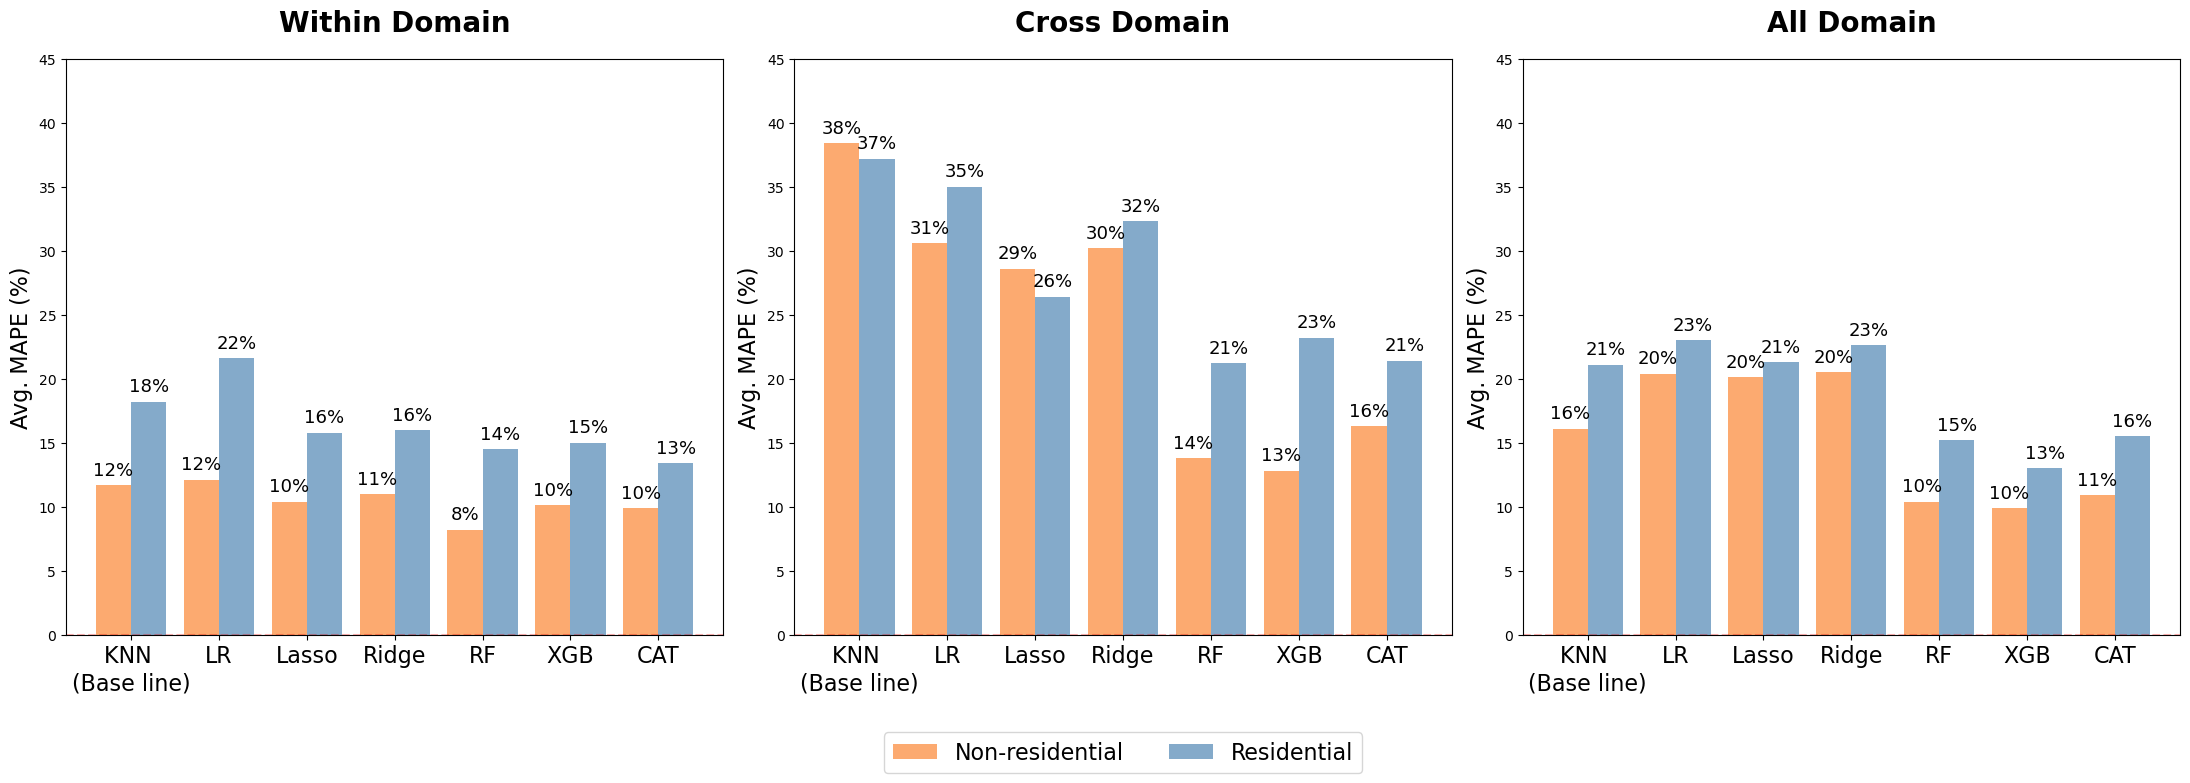

In [22]:
fig = create_model_comparison(
    comparison_table,
    metric='MAPE',
    save_path=f'../figures/model_plots/{feature_selection}/00_model_comparison_mape.png',
    y_limits=(0, 45)
)

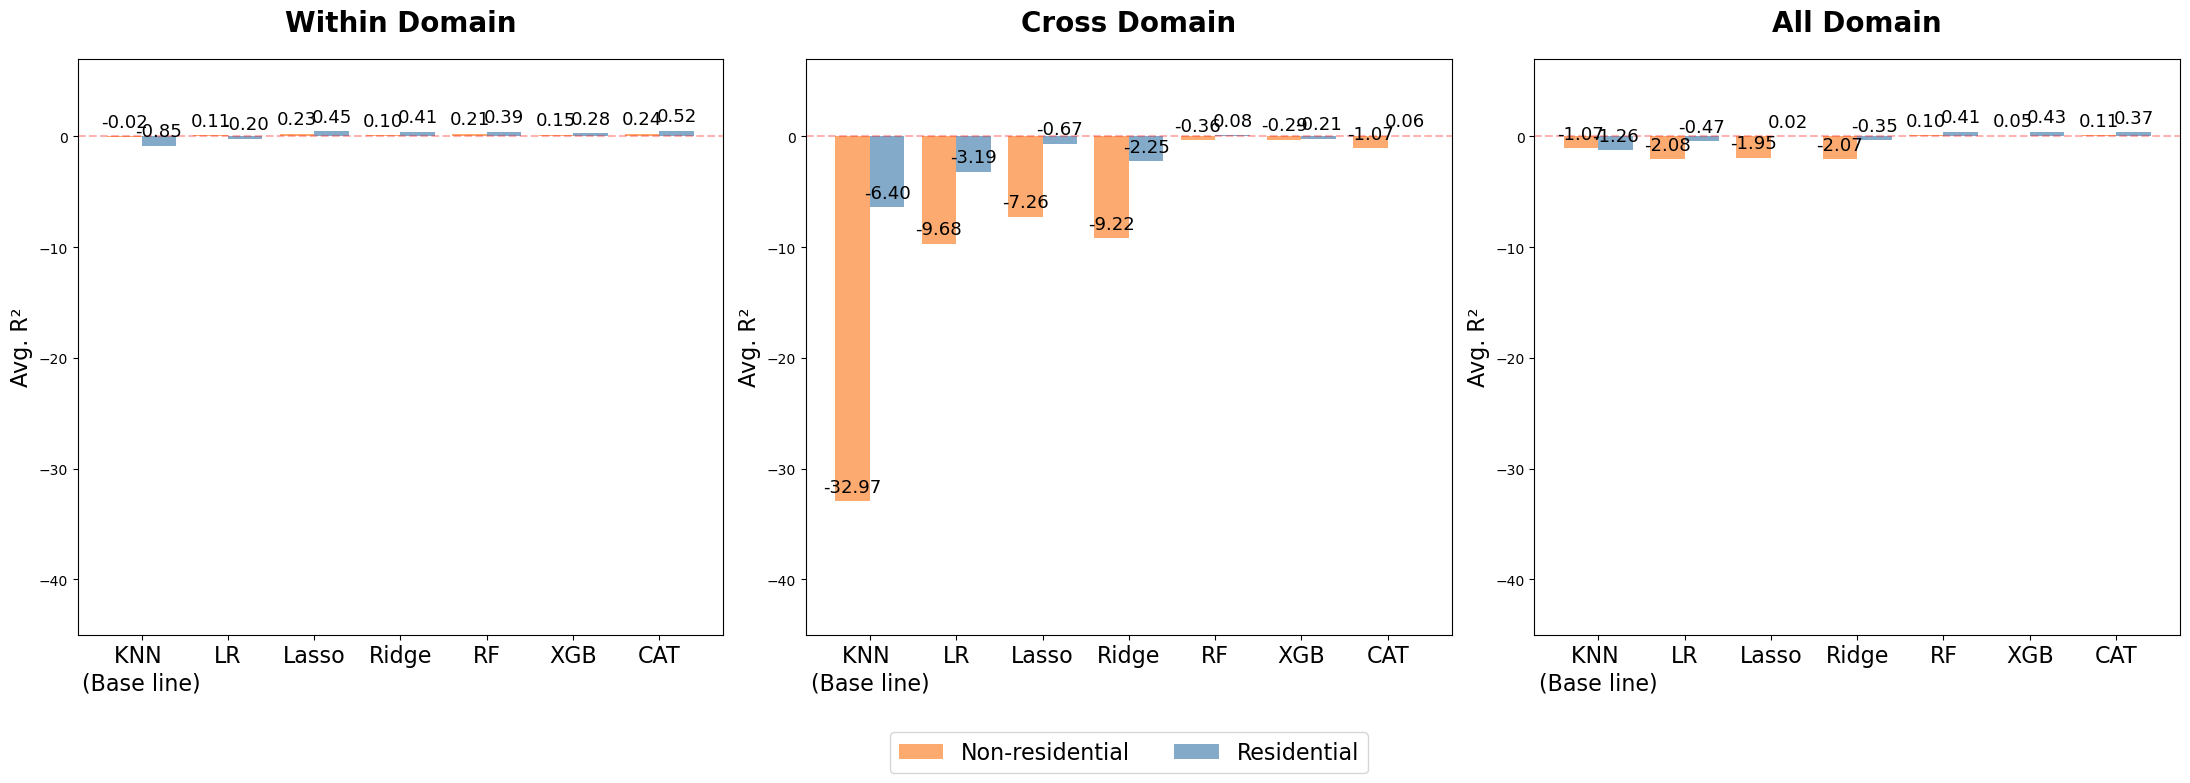

In [23]:
fig = create_model_comparison(
    comparison_table,
    metric='R²',
    save_path=f'../figures/model_plots/{feature_selection}/00_model_comparison_r2.png',
    y_limits=(-45, 7)
)

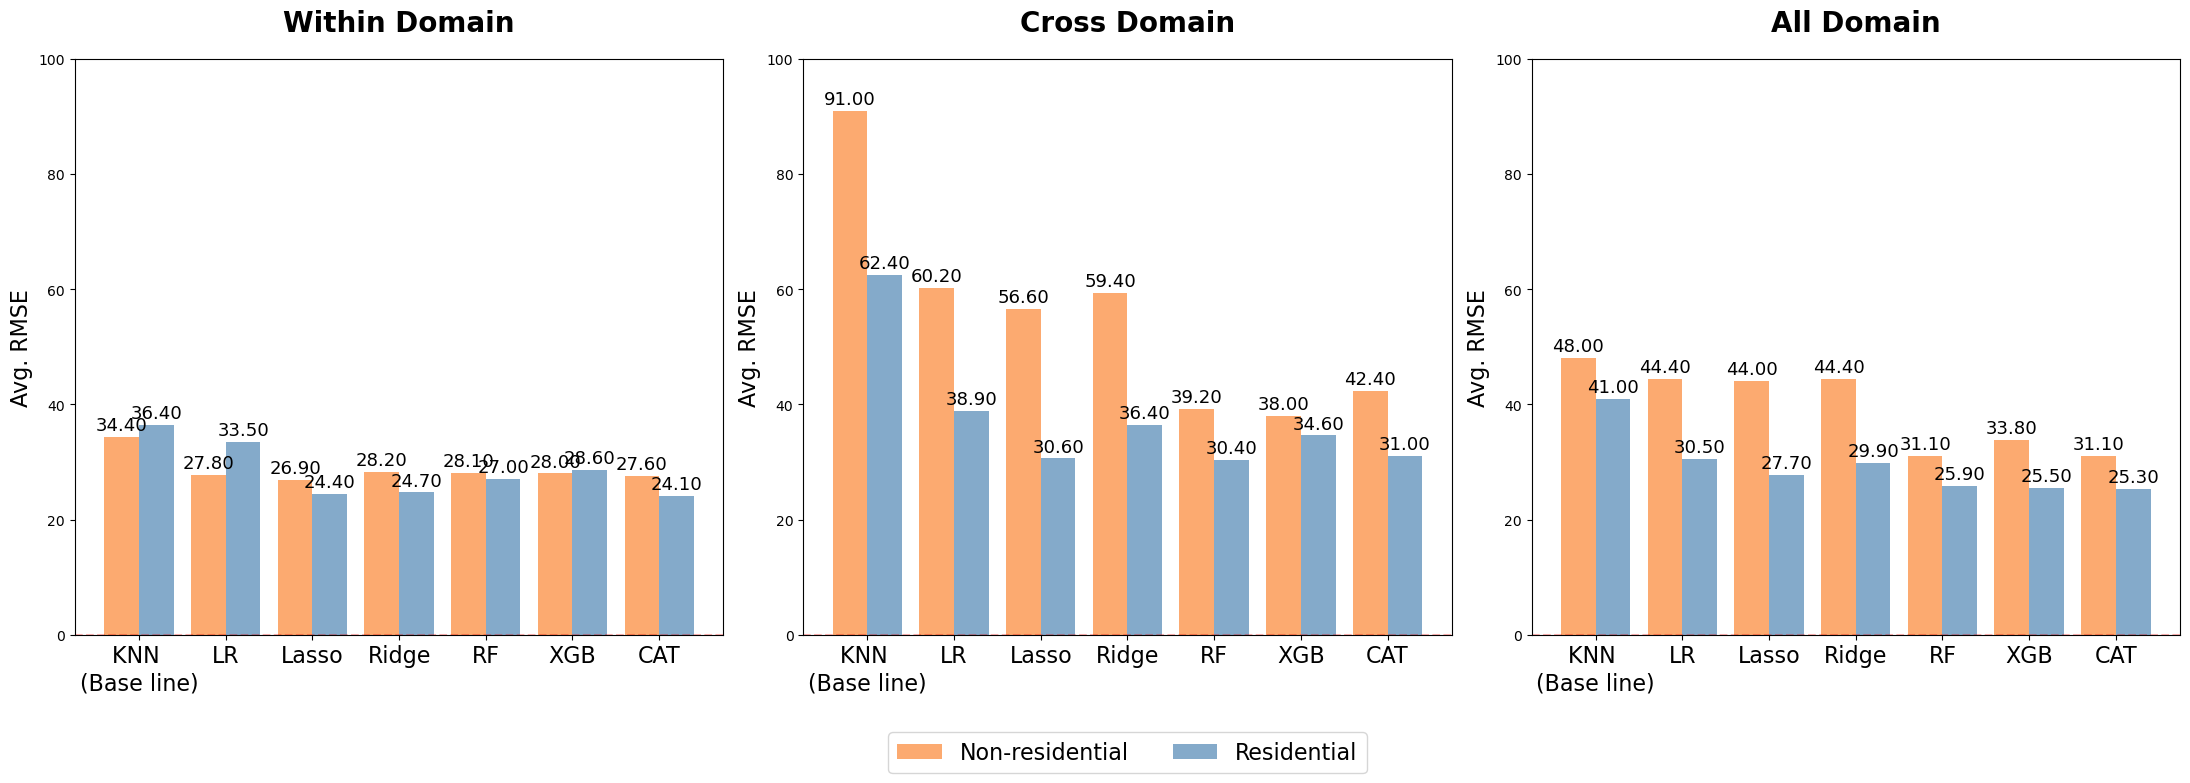

In [24]:
fig = create_model_comparison(
    comparison_table,
    metric='RMSE',
    save_path=f'../figures/model_plots/{feature_selection}/00_model_comparison_rmse.png',
    y_limits=(0, 100)
)